# 交通事故中人员伤亡多分类预测

1950083 自动化 刘智宇

## 导入必要的包

In [1]:
# 引入通用包

import numpy as np
import pandas as pd

# 解决中文乱码问题
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

In [2]:
# 引入sklearn包

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

## 常量&全局变量定义

In [3]:
# 数据集路径
trainDatasetPath = 'dataset/train.csv'
valDatasetPath = 'dataset/val.csv'
testDatasetPath = 'dataset/test.csv'

# 阈值设定
tooMuchNullValueFeatureThreshold = 500  # 若某个特征缺失的样本数量超过该值，认定为坏特征
tooMuchNullValueSampleThreshold = 5  # 若某个样本缺失的特征超过该值，认定为坏样本
tooMuchPossibleValueFeatureThreshold = 300  # 如果特征的可能的值多于该数，认定为没有参考性
tooLessPossibleValueFeatureThreshold = 2  # 如果特征的可能的值少于该数，认定为没有参考性

In [4]:
# 全局列别定义
unusedFeatureList = []
tooMuchNullValueFeatureList = []

tooMuchPossibleValueFeatureList = []
tooLessPossibleValueFeatureList = []

tooMuchNullValueSampleList = []

## 数据读取 & 预处理

In [5]:
# 数据读取
trainDatasetDF = pd.read_csv(filepath_or_buffer=trainDatasetPath, header=0, index_col=None)
valDatasetDF = pd.read_csv(filepath_or_buffer=valDatasetPath, header=0, index_col=0)
testDatasetDF = pd.read_csv(filepath_or_buffer=testDatasetPath, header=0, index_col=0)

# originTrainDatasetDF = pd.read_csv(filepath_or_buffer=trainDatasetPath, header=0, index_col=None)

In [6]:
# 查看数据集大小
print(trainDatasetPath, trainDatasetDF.shape)
print(valDatasetPath, valDatasetDF.shape)
print(testDatasetPath, testDatasetDF.shape)

dataset/train.csv (79786, 54)
dataset/val.csv (2836, 54)
dataset/test.csv (2836, 53)


In [7]:
# 计算样本标签分布
def computeLabelDistributeDict(datasetDF):
    labelDistributeDict = datasetDF['grav'].value_counts().to_dict()
    return labelDistributeDict

# 画出样本标签分布图
def plotLabelDistribute(distributeDict, pltTitle='标签分布'):
    plt.figure(figsize=(6,3))
    plt.title(pltTitle)
    plt.xlabel('标签名称')
    plt.ylabel('标签数量')
    plt.grid()
    plt.xticks(labels=['Unharmed','Killed','Hospitalized','Slightly'], ticks=[1,2,3,4])
    plt.bar(x=distributeDict.keys(), height=distributeDict.values())
    plt.show()

In [8]:
# 查看train和val数据集标签分布
trainLabelDistribute = computeLabelDistributeDict(trainDatasetDF)
print("trainLabelDistribute", trainLabelDistribute)
valLabelDistribute = computeLabelDistributeDict(valDatasetDF)
print("valLabelDistribute", valLabelDistribute)

trainLabelDistribute {1: 33264, 4: 31905, 3: 12537, 2: 2080}
valLabelDistribute {1: 745, 4: 724, 2: 713, 3: 654}


容易验证，数据集中没有label为空的样本

train和val数据的标签分布如下图所示

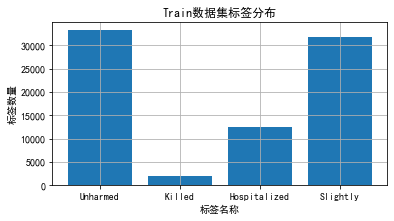

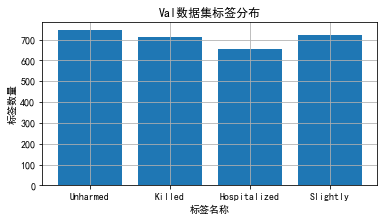

In [9]:
plotLabelDistribute(trainLabelDistribute, 'Train数据集标签分布')
plotLabelDistribute(valLabelDistribute, 'Val数据集标签分布')

可以发现Train数据集的样本类别分布不均匀，而Val数据集的分布较为均匀

所以在训练时需要对Train数据集根据类别进行重新采样，防止数据集不同类别样本分布偏差对结果的影响

In [69]:
# 计算数据集空值数量
def countAllNullValue(datasetDF):
    nullAmount = datasetDF.isnull().sum().sum()
    return nullAmount

In [11]:
trainDatasetNulls = countAllNullValue(trainDatasetDF)
print("trainDataset 的空值数量", trainDatasetNulls)
valDatasetNulls = countAllNullValue(valDatasetDF)
print("valDataset 的空值数量", valDatasetNulls)
testDatasetNulls = countAllNullValue(testDatasetDF)
print("testDataset 的空值数量", testDatasetNulls)

trainDataset 的空值数量 361556
valDataset 的空值数量 13081
testDataset 的空值数量 13126


可以发现验证集和测试集中也有很多空值，后续也需要进行处理

In [12]:
# 计算每个特征缺失值情况
def computeFeatureNullValue(datasetDF):
    featureNullDict = datasetDF.isnull().sum().sort_values(ascending=False).to_dict()
    return featureNullDict

# 可视化展示特征缺失值情况
def showFeatureNullValue(nullSortedDict, tops=20):
    plt.figure(figsize=(15,3))
    plt.grid()
    plt.xlabel("特征名称")
    plt.ylabel("特征缺失样本数量")
    plt.yscale('log')
    plt.title("缺失样本数量最多的Top%d特征 柱状图"%tops)
    plt.bar(x=list(nullSortedDict.keys())[0:tops], height=list(nullSortedDict.values())[0:tops])
    plt.show()

trainDatasetFeatureNullDict
{'lartpc': 79508, 'larrout': 79277, 'occutc': 78639, 'v2': 73891, 'v1': 14997, 'pr1': 10096, 'pr': 9672, 'circ': 4255, 'voie': 3712, 'vma': 1287, 'vosp': 1034, 'nbv': 1019, 'adr': 808, 'situ': 302, 'infra': 226, 'surf': 190, 'prof': 185, 'plan': 176, 'mois': 163, 'jour': 163, 'hrmn': 163, 'an': 163, 'catr': 163, 'lat': 163, 'col': 163, 'atm': 163, 'int': 163, 'agg': 163, 'com': 163, 'dep': 163, 'lum': 163, 'long': 163, 'obs': 0, 'etatp': 0, 'senc': 0, 'catv': 0, 'motor': 0, 'obsm': 0, 'choc': 0, 'manv': 0, 'locp': 0, 'actp': 0, 'an_nais': 0, 'secu3': 0, 'secu2': 0, 'secu1': 0, 'trajet': 0, 'sexe': 0, 'grav': 0, 'catu': 0, 'place': 0, 'num_veh': 0, 'id_vehicule': 0, 'Num_Acc': 0}


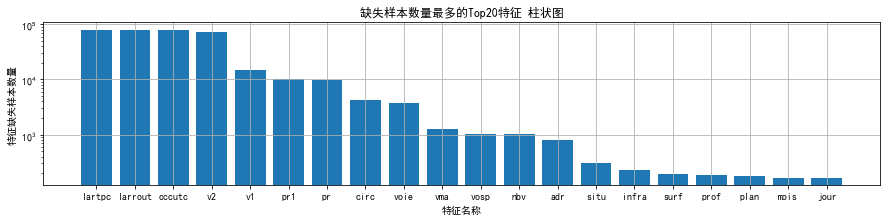

valDatasetFeatureNullDict
{'lartpc': 2817, 'larrout': 2811, 'occutc': 2803, 'v2': 2581, 'v1': 703, 'pr1': 418, 'pr': 396, 'voie': 165, 'circ': 97, 'vma': 54, 'adr': 36, 'vosp': 33, 'nbv': 26, 'situ': 11, 'infra': 9, 'prof': 8, 'surf': 8, 'plan': 7, 'mois': 7, 'jour': 7, 'hrmn': 7, 'an': 7, 'catr': 7, 'lat': 7, 'col': 7, 'atm': 7, 'int': 7, 'agg': 7, 'com': 7, 'dep': 7, 'lum': 7, 'long': 7, 'obs': 0, 'etatp': 0, 'senc': 0, 'catv': 0, 'motor': 0, 'obsm': 0, 'choc': 0, 'manv': 0, 'locp': 0, 'actp': 0, 'an_nais': 0, 'secu3': 0, 'secu2': 0, 'secu1': 0, 'trajet': 0, 'sexe': 0, 'grav': 0, 'catu': 0, 'place': 0, 'num_veh': 0, 'id_vehicule': 0, 'Num_Acc': 0}


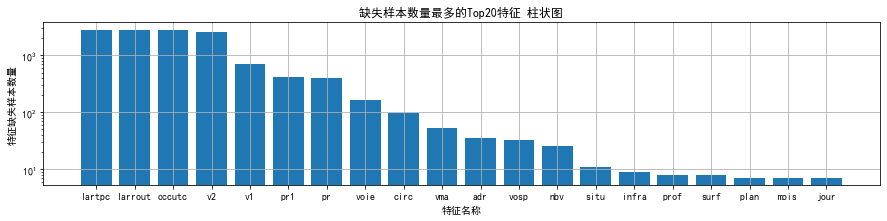

testDatasetFeatureNullDict
{'lartpc': 2829, 'larrout': 2815, 'occutc': 2795, 'v2': 2578, 'v1': 771, 'pr1': 410, 'pr': 387, 'voie': 170, 'circ': 110, 'vma': 65, 'adr': 34, 'nbv': 29, 'vosp': 28, 'situ': 10, 'prof': 7, 'infra': 7, 'plan': 6, 'jour': 5, 'mois': 5, 'hrmn': 5, 'an': 5, 'surf': 5, 'catr': 5, 'lat': 5, 'col': 5, 'atm': 5, 'int': 5, 'agg': 5, 'com': 5, 'dep': 5, 'lum': 5, 'long': 5, 'obs': 0, 'etatp': 0, 'senc': 0, 'catv': 0, 'motor': 0, 'obsm': 0, 'choc': 0, 'manv': 0, 'locp': 0, 'actp': 0, 'an_nais': 0, 'secu3': 0, 'secu2': 0, 'secu1': 0, 'trajet': 0, 'sexe': 0, 'catu': 0, 'place': 0, 'num_veh': 0, 'id_vehicule': 0, 'Num_Acc': 0}


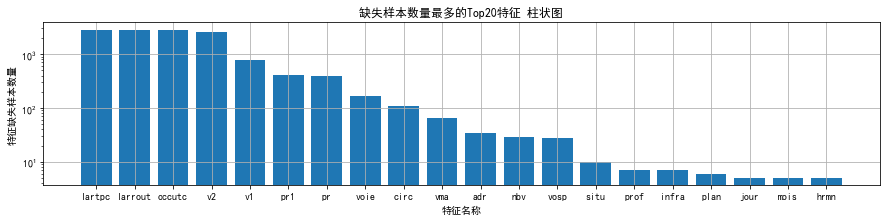

In [13]:
# 计算每个特征的缺失样本数量
print("trainDatasetFeatureNullDict")
trainDatasetFeatureNullDict = computeFeatureNullValue(trainDatasetDF)
print(trainDatasetFeatureNullDict)
showFeatureNullValue(trainDatasetFeatureNullDict)

print("valDatasetFeatureNullDict")
valDatasetFeatureNullDict = computeFeatureNullValue(valDatasetDF)
print(valDatasetFeatureNullDict)
showFeatureNullValue(valDatasetFeatureNullDict)

print("testDatasetFeatureNullDict")
testDatasetFeatureNullDict = computeFeatureNullValue(testDatasetDF)
print(testDatasetFeatureNullDict)
showFeatureNullValue(testDatasetFeatureNullDict)

可以看出trainDataset、valDataset、testDataset的缺失值分布基本一致

In [14]:
# 将缺失过多样本的特征提取出来
# tooMuchNullValueFeatureList = []
tooMuchNullValueFeatureList.extend(key for key in trainDatasetFeatureNullDict if trainDatasetFeatureNullDict[key] > tooMuchNullValueFeatureThreshold)
print(tooMuchNullValueFeatureList)

['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr']


In [15]:
# 删除缺失样本过多的特征
trainDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')
valDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')
testDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')

unusedFeatureList.extend(tooMuchNullValueFeatureList)  # 将这些缺失样本过多的特征作为不会使用到的特征
print("删除后剩余的特征 : ", trainDatasetDF.columns)

删除后剩余的特征 :  Index(['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'lat', 'long', 'catr', 'prof', 'plan', 'surf',
       'infra', 'situ', 'id_vehicule', 'num_veh', 'place', 'catu', 'grav',
       'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp',
       'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor'],
      dtype='object')


将缺失样本数量超过阈值的特征进行删除，并查看删除后剩余的各个特征空值的情况

{'situ': 302, 'infra': 226, 'surf': 190, 'prof': 185, 'plan': 176, 'atm': 163, 'jour': 163, 'catr': 163, 'long': 163, 'col': 163, 'lat': 163, 'int': 163, 'agg': 163, 'com': 163, 'dep': 163, 'lum': 163, 'hrmn': 163, 'an': 163, 'mois': 163, 'obs': 0, 'actp': 0, 'etatp': 0, 'senc': 0, 'catv': 0, 'Num_Acc': 0, 'obsm': 0, 'choc': 0, 'manv': 0, 'secu3': 0, 'locp': 0, 'id_vehicule': 0, 'secu2': 0, 'secu1': 0, 'trajet': 0, 'an_nais': 0, 'sexe': 0, 'grav': 0, 'catu': 0, 'place': 0, 'num_veh': 0, 'motor': 0}


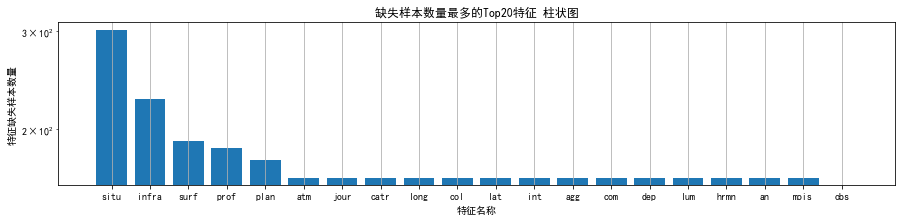

trainDatasetDF shape :  (79786, 41)


In [16]:
# 检查删除后每个特征的缺失样本数量
trainDatasetFeatureNullDict = computeFeatureNullValue(trainDatasetDF)
print(trainDatasetFeatureNullDict)
showFeatureNullValue(trainDatasetFeatureNullDict)
print("trainDatasetDF shape : ", trainDatasetDF.shape)

In [17]:
# 计算每个样本的空特征的数量
def computeSampleNullValue(datasetDF):
    sampleNullDict = datasetDF.T.isnull().sum().sort_values(ascending=False).to_dict()
    return sampleNullDict

In [18]:
tooMuchNullValueSampleList = []
trainDatasetSampleNullDict = computeSampleNullValue(trainDatasetDF)
tooMuchNullValueSampleList.extend(key for key in trainDatasetSampleNullDict if trainDatasetSampleNullDict[key] > tooMuchNullValueSampleThreshold)
# print(tooMuchNullValueSampleList)
print("缺失%d个以上特征的样本数量 : "%tooMuchNullValueSampleThreshold, len(tooMuchNullValueSampleList))

缺失5个以上特征的样本数量 :  163


In [19]:
# 只有trainDataset才参与drop
trainDatasetDF.drop(index=tooMuchNullValueSampleList, inplace=True, errors='ignore')
print("删除后trainDataset的shape : ", trainDatasetDF.shape)
print('trainDataset的空值数量',  countAllNullValue(trainDatasetDF))

删除后trainDataset的shape :  (79623, 41)
trainDataset的空值数量 264


显然，可能值过多或过少的特征都不具有参考性

In [20]:
# 字典方式记录特征可能值
def recordFeaturePossibleValueDict(datasetDF):
    featureAllPossibleValueDict = {}
    for featureName in datasetDF:
        oneFeaturePossibleValueCountDict = datasetDF[featureName].value_counts().to_dict()
        featureAllPossibleValueDict[featureName] = oneFeaturePossibleValueCountDict
    return featureAllPossibleValueDict

# 计算特征可能值数量。字典方式
def countFeaturePossibleValueDict(datasetDF):
    featurePossiblesValueAmountDict = {}
    for featureName in datasetDF:
        oneFeaturePossibleValueCountDict = datasetDF[featureName].value_counts().to_dict()
        featurePossiblesValueAmountDict[featureName] = len(oneFeaturePossibleValueCountDict)
    return featurePossiblesValueAmountDict

# 图形化展示特征可能值数量
def showFeaturePossibleValueCount(possiblesValueAmountDict):
    plt.figure(figsize=(25,3))
    plt.grid()
    plt.xlabel("特征名称")
    plt.ylabel("特征可能值数量(对数显式)")
    plt.yscale('log')
    plt.title("特征可能值统计 柱状图")
    plt.bar(x=list(possiblesValueAmountDict.keys()), height=list(possiblesValueAmountDict.values()))
    plt.show()

# 图形化展示特征可能值及其分布
def showFeaturePossibleValueRecord(possiblesValueRecordDict, subplotCols=5):
    subFigNumbers = len(possiblesValueRecordDict)
    subplotRows = (subFigNumbers-1)//subplotCols + 1
    print('subplotRows : ', subplotRows)
    plt.figure(figsize=(25,30))
    for idx, subDictKey in enumerate(possiblesValueRecordDict):
        subDict = possiblesValueRecordDict[subDictKey]
        plt.subplot(subplotRows,subplotCols, idx+1)
        plt.title(subDictKey)
        plt.xlabel(subDictKey+'的可能值')
        plt.ylabel('可能值个数')
        plt.grid()
        plt.bar(x = list(subDict.keys()), height=list(subDict.values()))

In [21]:
featurePossibleValueCountDict = countFeaturePossibleValueDict(trainDatasetDF)
print(featurePossibleValueCountDict)

{'Num_Acc': 48304, 'jour': 31, 'mois': 12, 'an': 1, 'hrmn': 1347, 'lum': 5, 'dep': 107, 'com': 10018, 'agg': 2, 'int': 9, 'atm': 10, 'col': 8, 'lat': 46055, 'long': 46428, 'catr': 8, 'prof': 4, 'plan': 4, 'surf': 9, 'infra': 10, 'situ': 7, 'id_vehicule': 65846, 'num_veh': 27, 'place': 10, 'catu': 3, 'grav': 4, 'sexe': 2, 'an_nais': 103, 'trajet': 8, 'secu1': 11, 'secu2': 11, 'secu3': 10, 'locp': 11, 'actp': 13, 'etatp': 4, 'senc': 5, 'catv': 31, 'obs': 19, 'obsm': 8, 'choc': 11, 'manv': 28, 'motor': 8}


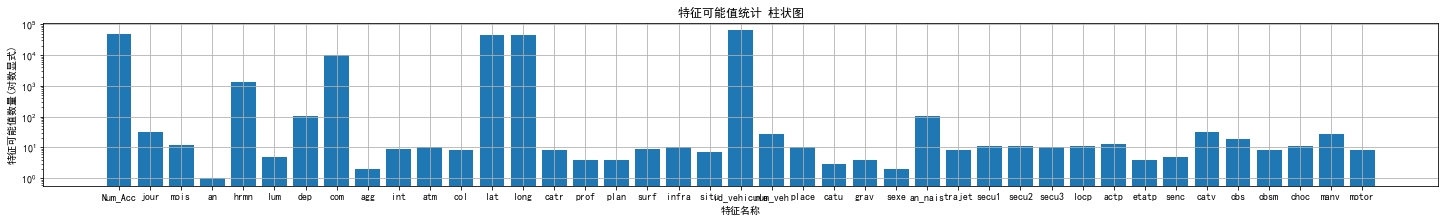

In [22]:
showFeaturePossibleValueCount(featurePossibleValueCountDict)

In [23]:
tooMuchPossibleValueFeatureList = [feature for feature in featurePossibleValueCountDict if featurePossibleValueCountDict[feature] > tooMuchPossibleValueFeatureThreshold]
tooLessPossibleValueFeatureList = [feature for feature in featurePossibleValueCountDict if featurePossibleValueCountDict[feature] < tooLessPossibleValueFeatureThreshold]

print("tooMuchValueFeatureList : ", tooMuchPossibleValueFeatureList)
print("tooLessValueFeatureList : ", tooLessPossibleValueFeatureList)

tooMuchValueFeatureList :  ['Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule']
tooLessValueFeatureList :  ['an']


In [24]:
unusedFeatureList.extend(tooMuchPossibleValueFeatureList)
unusedFeatureList.extend(tooLessPossibleValueFeatureList)
print('unusedFeatureList', unusedFeatureList)
trainDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
trainDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
print("trainDatasetDF.shape", trainDatasetDF.shape)
valDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
valDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
print("valDatasetDF.shape", valDatasetDF.shape)
testDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
testDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
print("testDatasetDF.shape", testDatasetDF.shape)  # test少了grav列

unusedFeatureList ['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an']
trainDatasetDF.shape (79623, 34)
valDatasetDF.shape (2836, 34)
testDatasetDF.shape (2836, 33)


subplotRows :  7


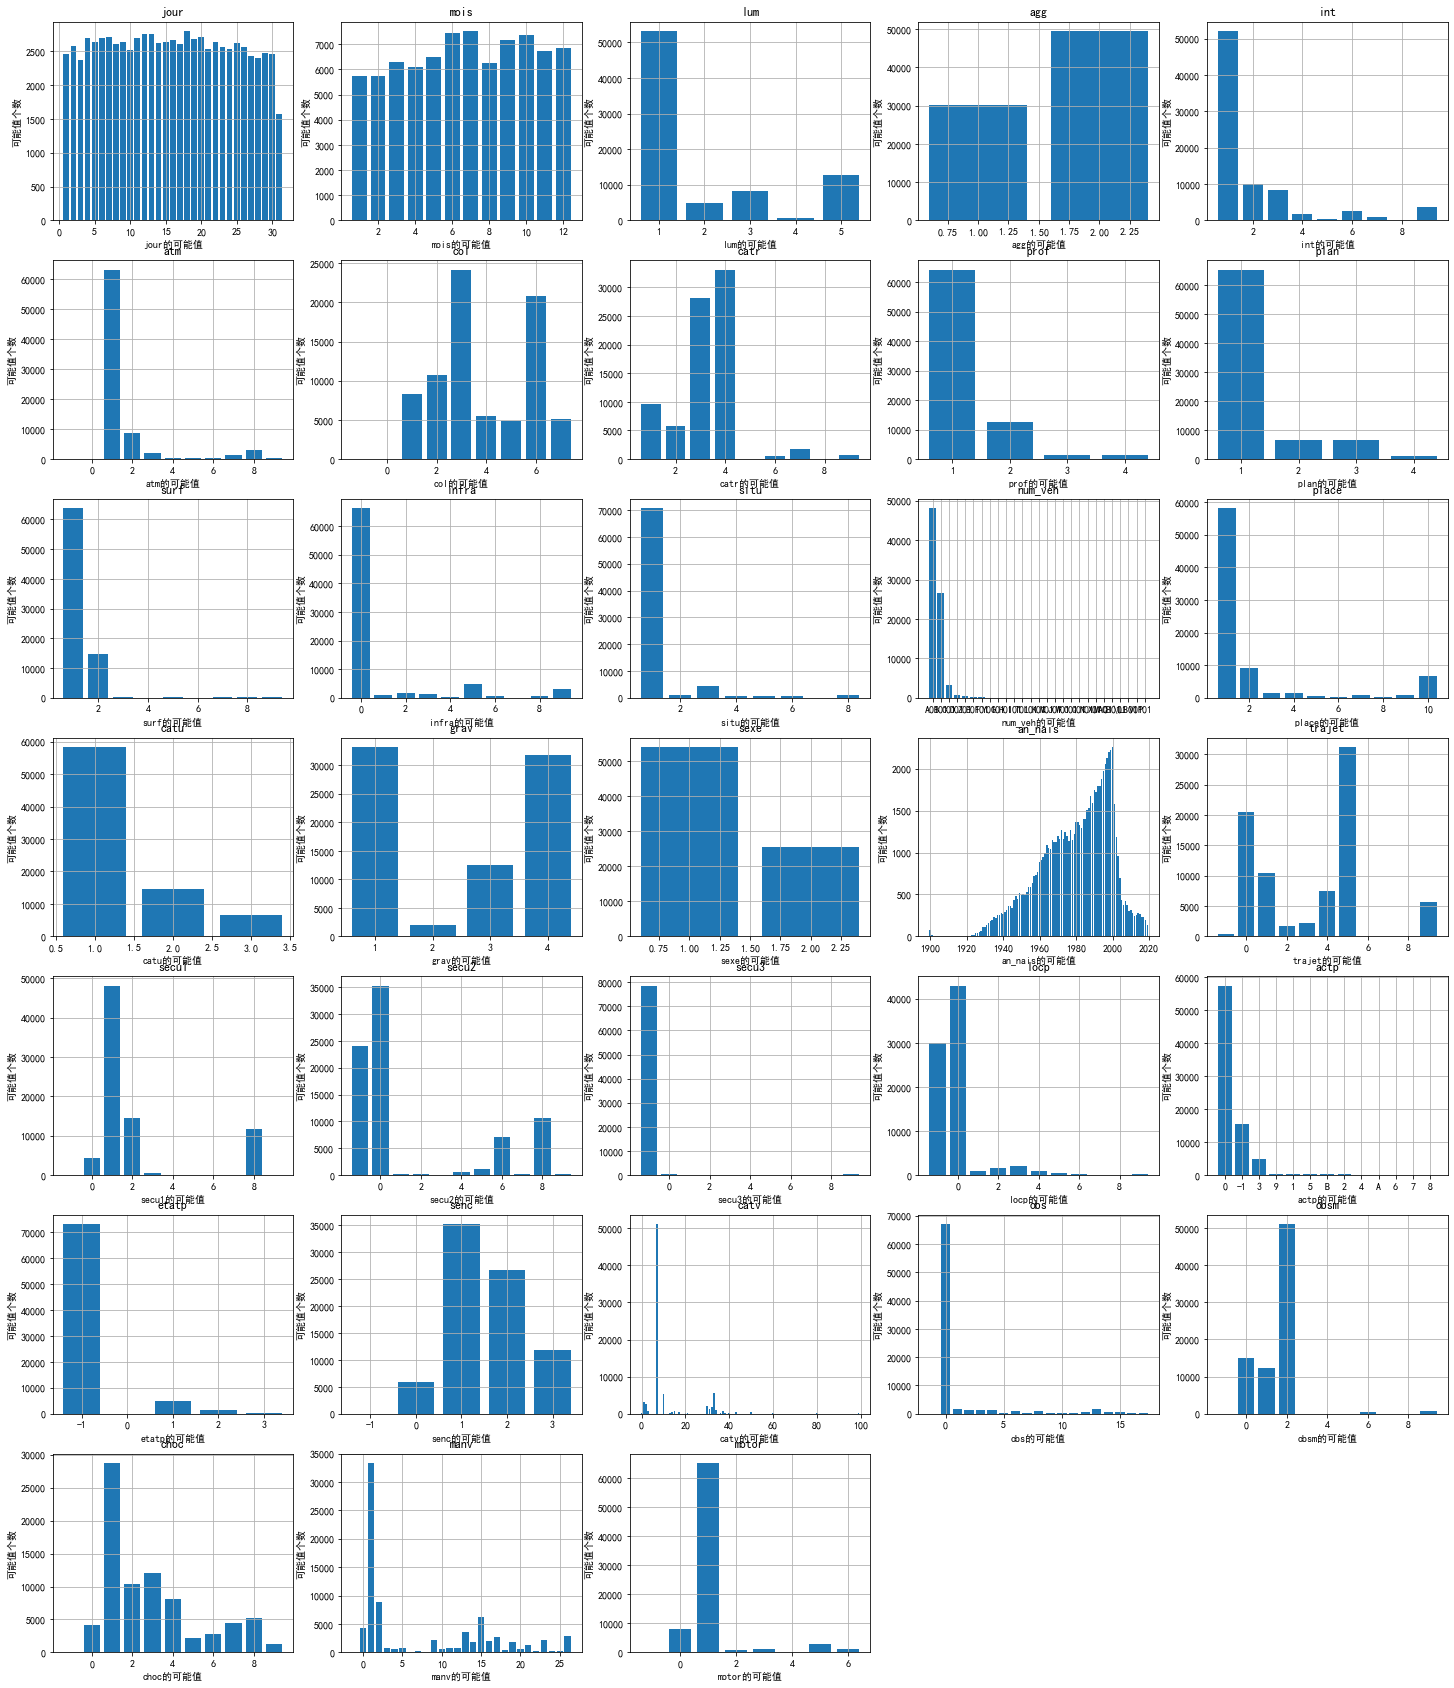

In [25]:
featurePossibleValueRecordDict = recordFeaturePossibleValueDict(trainDatasetDF)
featurePossibleValueRecordDictCopy = featurePossibleValueRecordDict.copy()
featurePossibleValueRecordDictCopy.pop('dep')
# for key in featurePossibleValueRecordDict:
#     print(key, ' : ', featurePossibleValueRecordDict[key].keys())

showFeaturePossibleValueRecord(featurePossibleValueRecordDictCopy)

In [27]:
print(unusedFeatureList)

['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an']


从上图可以看出obs(6,4),secu3(5,3),catv(6,3),infra(3,2),situ(3,3)的可能值较为集中，不具有参考性，手动去除

In [28]:
manualLowVarianceFeatureList = ['obs', 'secu3', 'catv', 'infra', 'situ']
unusedFeatureList.extend(manualLowVarianceFeatureList)
print(manualLowVarianceFeatureList)
print(unusedFeatureList)

['obs', 'secu3', 'catv', 'infra', 'situ']
['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an', 'obs', 'secu3', 'catv', 'infra', 'situ']


In [29]:
trainDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('trainDatasetDF.shape', trainDatasetDF.shape)
valDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('valDatasetDF.shape', valDatasetDF.shape)
testDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('testDatasetDF.shape', testDatasetDF.shape)

trainDatasetDF.shape (79623, 29)
valDatasetDF.shape (2836, 29)
testDatasetDF.shape (2836, 28)


In [30]:
# 查看剩余特征的属性，有些为object，其他多为float和int
print(trainDatasetDF.dtypes.to_dict())

print('trainDatasetDF.ObjectTypeFeature')
print(trainDatasetDF.select_dtypes(include=['object']).describe())
print('valDatasetDF.ObjectTypeFeature')
print(valDatasetDF.select_dtypes(include=['object']).describe())
print('testDatasetDF.ObjectTypeFeature')
print(testDatasetDF.select_dtypes(include=['object']).describe())

{'jour': dtype('float64'), 'mois': dtype('float64'), 'lum': dtype('float64'), 'dep': dtype('O'), 'agg': dtype('float64'), 'int': dtype('float64'), 'atm': dtype('float64'), 'col': dtype('float64'), 'catr': dtype('float64'), 'prof': dtype('float64'), 'plan': dtype('float64'), 'surf': dtype('float64'), 'num_veh': dtype('O'), 'place': dtype('int64'), 'catu': dtype('int64'), 'grav': dtype('int64'), 'sexe': dtype('int64'), 'an_nais': dtype('int64'), 'trajet': dtype('int64'), 'secu1': dtype('int64'), 'secu2': dtype('int64'), 'locp': dtype('int64'), 'actp': dtype('O'), 'etatp': dtype('int64'), 'senc': dtype('int64'), 'obsm': dtype('int64'), 'choc': dtype('int64'), 'manv': dtype('int64'), 'motor': dtype('int64')}
trainDatasetDF.ObjectTypeFeature
          dep num_veh   actp
count   79623   79623  79623
unique    107      27     13
top        75     A01      0
freq     7240   48075  57380
valDatasetDF.ObjectTypeFeature
         dep num_veh  actp
count   2829    2836  2836
unique   106       9   

经过对整个数据集的分析，dep、num_veh没什么用，故删去

In [31]:
experienceDropFeatureList = ['dep', 'num_veh']
trainDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
valDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
testDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
unusedFeatureList.extend(experienceDropFeatureList)
print('unusedFeatureList : ', unusedFeatureList)
print('trainDatasetDF shape : ', trainDatasetDF.shape)
print(trainDatasetDF.columns)

unusedFeatureList :  ['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an', 'obs', 'secu3', 'catv', 'infra', 'situ', 'dep', 'num_veh']
trainDatasetDF shape :  (79623, 27)
Index(['jour', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof',
       'plan', 'surf', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet',
       'secu1', 'secu2', 'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc',
       'manv', 'motor'],
      dtype='object')


In [70]:
trainDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('trainDatasetDF.shape', trainDatasetDF.shape)
valDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('valDatasetDF.shape', valDatasetDF.shape)
testDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('testDatasetDF.shape', testDatasetDF.shape)

trainDatasetDF.shape (79623, 27)
valDatasetDF.shape (2836, 27)
testDatasetDF.shape (2836, 26)


当然还存在空值，我决定用众数来补齐

In [32]:
# 获取众数
def getFeatureValueModeDict(datasetDF):
    modeDict = datasetDF.mode().T.to_dict()[0]
    return modeDict

# 使用众数进行填充
def imputeFeatureValueByMode(datasetDF, datasetModeDict):
    for feature in datasetDF:
        tempImputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=datasetModeDict[feature])
        datasetDF[feature] = tempImputer.fit_transform(datasetDF[feature].values.reshape(-1,1))

In [33]:
# 获取剩余特征的众数，并存储在字典中
trainFeatureValueModeDict = getFeatureValueModeDict(trainDatasetDF)
print(trainFeatureValueModeDict)
print(type(trainFeatureValueModeDict))

{'jour': 18.0, 'mois': 7.0, 'lum': 1.0, 'agg': 2.0, 'int': 1.0, 'atm': 1.0, 'col': 3.0, 'catr': 4.0, 'prof': 1.0, 'plan': 1.0, 'surf': 1.0, 'place': 1, 'catu': 1, 'grav': 1, 'sexe': 1, 'an_nais': 2000, 'trajet': 5, 'secu1': 1, 'secu2': 0, 'locp': 0, 'actp': '0', 'etatp': -1, 'senc': 1, 'obsm': 2, 'choc': 1, 'manv': 1, 'motor': 1}
<class 'dict'>


In [34]:
# 都使用train的Mode进行补空
imputeFeatureValueByMode(trainDatasetDF, trainFeatureValueModeDict)
imputeFeatureValueByMode(valDatasetDF, trainFeatureValueModeDict)
imputeFeatureValueByMode(testDatasetDF, trainFeatureValueModeDict)
print(countAllNullValue(trainDatasetDF))
print(countAllNullValue(valDatasetDF))
print(countAllNullValue(testDatasetDF))

0
0
0


可以通过impute操作后，筛选后的各个Dataset已经没有空数据了

In [35]:
# 对val和test同时使用train所fit的LabelEncoder
def applyLabelEncoderToDatasetDF(trainDF, valDF, testDF):
    labelEncoderList = []
    objectFeature = trainDatasetDF.select_dtypes(include=['object']).columns.to_list()
    for feature in objectFeature:
        tempLabelEncoder = LabelEncoder()
        trainDF[feature] = tempLabelEncoder.fit_transform(trainDF[feature].to_list())
        valDF[feature] = tempLabelEncoder.transform(valDF[feature].to_list())
        testDF[feature] = tempLabelEncoder.transform(testDF[feature].to_list())
        # print('class_:', tempLabelEncoder.classes_)
        labelEncoderList.append(tempLabelEncoder)
    return labelEncoderList

In [36]:
# 对三个数据集的object类型feature使用相同的LabelEncoder
print("object类型的features : ", trainDatasetDF.select_dtypes(include=['object']).columns.to_list())
print('----------Before Label Encoder----------')
print('trainDatasetDF   : ', trainDatasetDF['actp'].to_list()[0:10])
print('valDatasetDF     : ', valDatasetDF['actp'].to_list()[0:10])
print('testDatasetDF    : ', testDatasetDF['actp'].to_list()[0:10])
LabelEncoderList = applyLabelEncoderToDatasetDF(trainDatasetDF, valDatasetDF, testDatasetDF)
print('----------After Label Encoder----------')
print('trainDatasetDF   : ', trainDatasetDF['actp'].to_list()[0:10])
print('valDatasetDF     : ', valDatasetDF['actp'].to_list()[0:10])
print('testDatasetDF    : ', testDatasetDF['actp'].to_list()[0:10])

object类型的features :  ['actp']
----------Before Label Encoder----------
trainDatasetDF   :  ['-1', '-1', '0', '0', '0', '0', '0', '0', '0', '0']
valDatasetDF     :  ['0', '3', '0', '0', '0', '0', '0', '0', '0', '0']
testDatasetDF    :  ['0', '5', '-1', '0', '0', '0', '0', '0', '-1', '-1']
----------After Label Encoder----------
trainDatasetDF   :  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
valDatasetDF     :  [1, 4, 1, 1, 1, 1, 1, 1, 1, 1]
testDatasetDF    :  [1, 6, 0, 1, 1, 1, 1, 1, 0, 0]


In [37]:
print(trainDatasetDF['actp'].dtype)

int64


可视化查看相关性矩阵

<AxesSubplot:>

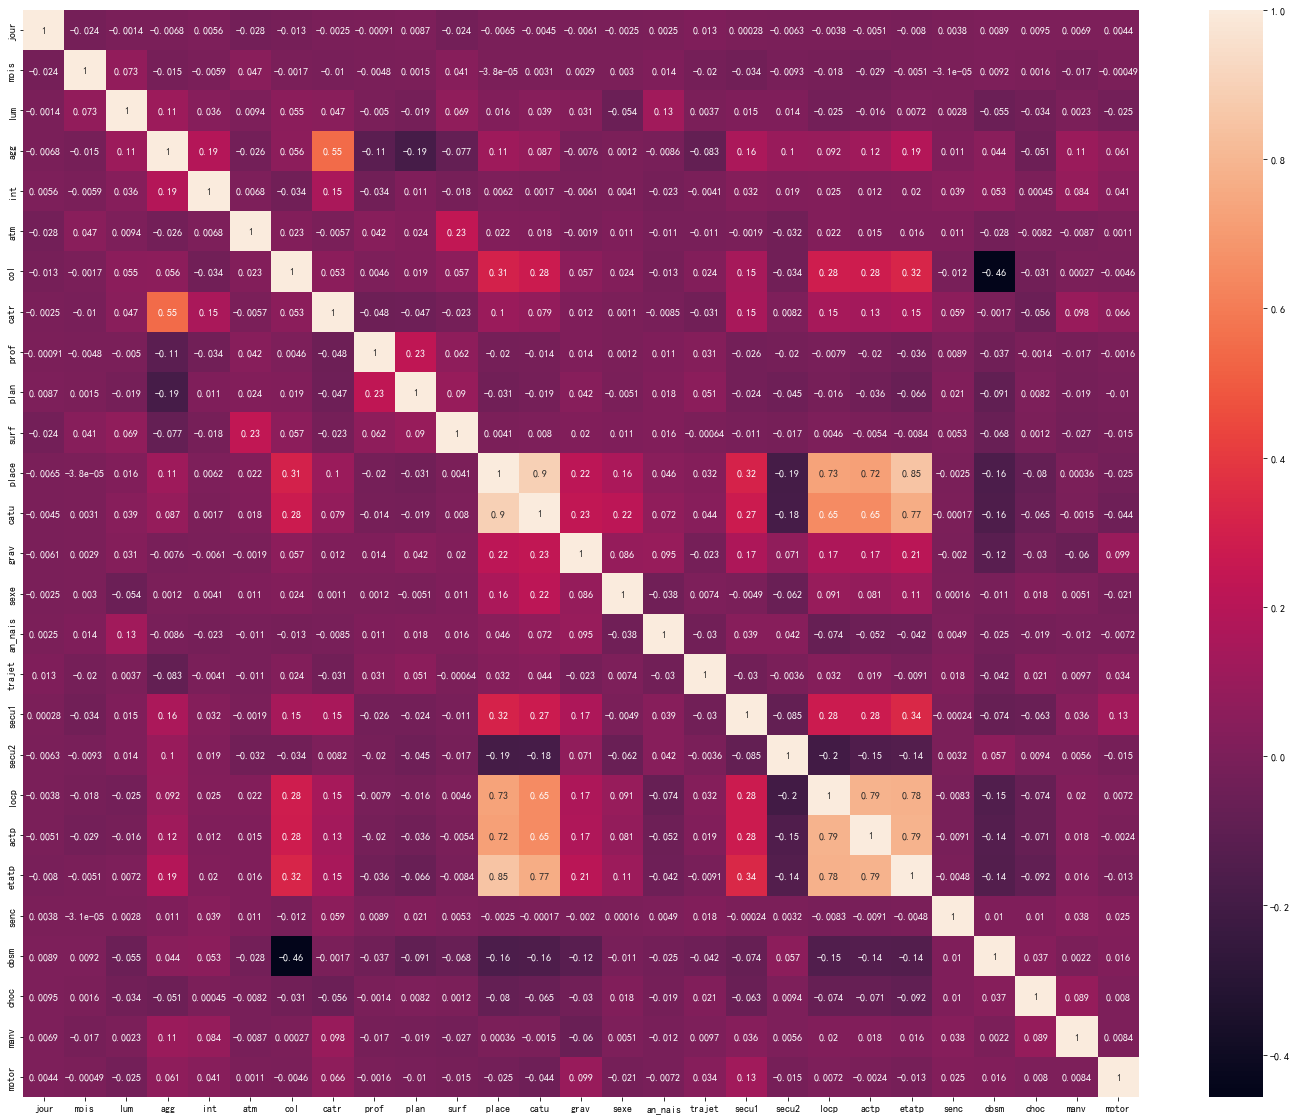

In [38]:
plt.figure(figsize=(25,20))
sns.heatmap(trainDatasetDF.corr(), annot=True)

查看各个特征之间的相关性。
可以看出相关度不是特别高。
而且我对各个特征之间的相互关系没有背景知识。
所以也没有随意删除、降维。

In [39]:
trainDatasetDFLabelCorrDict = trainDatasetDF.corr()['grav'].sort_values(ascending=False).to_dict()  # .corr是dataframe的相关性矩阵
print(trainDatasetDFLabelCorrDict)

{'grav': 1.0, 'catu': 0.2349162856995726, 'place': 0.2168139600983853, 'etatp': 0.21097767698577868, 'actp': 0.1717874785934596, 'locp': 0.1688134455713254, 'secu1': 0.16675027603124248, 'motor': 0.0994186992755378, 'an_nais': 0.09525964919842449, 'sexe': 0.08622400347827294, 'secu2': 0.07125298507228821, 'col': 0.05685906675251148, 'plan': 0.04152923584695603, 'lum': 0.030525213422915698, 'surf': 0.020422560848235686, 'prof': 0.013925131164322108, 'catr': 0.012379186495786565, 'mois': 0.002871941189349718, 'atm': -0.0018974882773658498, 'senc': -0.001959617555074392, 'jour': -0.006058962640611064, 'int': -0.006076828969580915, 'agg': -0.007601762424708353, 'trajet': -0.023304153681508316, 'choc': -0.03033176892405366, 'manv': -0.06008140182863687, 'obsm': -0.11814181492673197}


还需要对categorical和numerical的feature做处理
1. categorical : onehot编码
2. numerical : 去均值、方差归一化

In [40]:
print('trainDatasetDF.shape : ', trainDatasetDF.shape)

trainDatasetDF.shape :  (79623, 27)


In [41]:
AllFeatureList =    ['jour', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof','plan', 'surf', \
                    'place', 'catu', 'grav', 'sexe', 'an_nais','trajet', 'secu1', 'secu2', \
                    'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc', 'manv', 'motor']
categoricalFeatureList = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof','plan', 'surf', \
                        'place', 'catu', 'sexe', 'trajet', 'secu1', 'secu2', \
                        'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc', 'manv', 'motor']  # 没有写 'grav', 
numericalFeatureList = ['an_nais', 'mois', 'jour']

In [42]:
print('AllFeatureList', len(AllFeatureList))  # all_feature需要与dataset的shape对应
print(AllFeatureList)
print('categoricalFeatureList', len(categoricalFeatureList))
print(categoricalFeatureList)
print('numericalFeatureList', len(numericalFeatureList))
print(numericalFeatureList)

AllFeatureList 27
['jour', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc', 'manv', 'motor']
categoricalFeatureList 23
['lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'place', 'catu', 'sexe', 'trajet', 'secu1', 'secu2', 'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc', 'manv', 'motor']
numericalFeatureList 3
['an_nais', 'mois', 'jour']


In [71]:
# 使用独热编码处理类别特征
def handleCategoricalFeature(datasetDF, categoricalFeatureList):
    # 注意这里drop_first是为了防止dummy variable trap问题
    tempDatasetDF = pd.get_dummies(data=datasetDF, prefix_sep='==', columns=categoricalFeatureList, drop_first=True)
    return tempDatasetDF

# def handleNumericalFeature(datasetDF, numericalFeatureList):
#     scaler = StandardScaler()
#     for feature in numericalFeatureList:
#         datasetDF[feature] = scaler.fit_transform(datasetDF[feature].to_numpy().reshape(-1,1))
#         print(datasetDF[feature].to_list()[0:10])

In [44]:
trainDatasetDFLen = trainDatasetDF.shape[0]
valDatasetDFLen = valDatasetDF.shape[0]
testDatasetDFLen = testDatasetDF.shape[0]

# 将三个数据合并，方便进行onehot编码
overallDatasetDF = pd.concat([trainDatasetDF, valDatasetDF, testDatasetDF], axis=0)
print(overallDatasetDF.shape, trainDatasetDFLen, valDatasetDFLen, testDatasetDFLen)

overallDatasetProcessedDF = handleCategoricalFeature(overallDatasetDF, categoricalFeatureList)
print('overallDatasetProcessedDF.shape', overallDatasetProcessedDF.shape)

(85295, 27) 79623 2836 2836
overallDatasetProcessedDF.shape (85295, 173)


In [45]:
trainDatasetProcessedDF = overallDatasetProcessedDF.iloc[0:trainDatasetDFLen, :]
print("trainDatasetProcessedDF.shape : ", trainDatasetProcessedDF.shape)

valDatasetProcessedDF = overallDatasetProcessedDF.iloc[trainDatasetDFLen:trainDatasetDFLen+valDatasetDFLen, :]
print("valDatasetProcessedDF.shape : ", valDatasetProcessedDF.shape)

testDatasetProcessedDF = overallDatasetProcessedDF.iloc[trainDatasetDFLen+valDatasetDFLen:, :]
testDatasetProcessedDF = testDatasetProcessedDF.copy()
testDatasetProcessedDF.drop(columns=['grav'], inplace=True)  # 不要忘记删除grav列
print("testDatasetProcessedDF.shape : ", testDatasetProcessedDF.shape)

trainDatasetProcessedDF.shape :  (79623, 173)
valDatasetProcessedDF.shape :  (2836, 173)
testDatasetProcessedDF.shape :  (2836, 172)


## 采样

由于训练集的label分布并不均匀，故需要进行采样

In [46]:
def getSampledDatasetDF(datasetDF):
    labelDistributeDict = computeLabelDistributeDict(datasetDF)
    maxLabelValue = max(labelDistributeDict, key=labelDistributeDict.get)
    maxLabelValueAmount = labelDistributeDict[maxLabelValue]//8

    sampledDatasetDF = datasetDF.groupby('grav').get_group(maxLabelValue).sample(maxLabelValueAmount, replace=True, random_state=42)

    for labelValue in labelDistributeDict:
        if labelValue != maxLabelValue:
            tempValueDF = datasetDF.groupby('grav').get_group(labelValue).sample(maxLabelValueAmount, replace=True, random_state=42)
            sampledDatasetDF = pd.concat([sampledDatasetDF, tempValueDF], axis=0)
    return sampledDatasetDF

In [47]:
# 重新计算样本分布矩阵
trainLabelDistributeDict = computeLabelDistributeDict(trainDatasetDF)
print(trainLabelDistributeDict)
# 计算出现频率最多的标签及其出现次数
mostCommonLabelValue = max(trainLabelDistributeDict, key=trainLabelDistributeDict.get)
mostCommonLabelValueAmount = trainLabelDistributeDict[mostCommonLabelValue]
print(mostCommonLabelValue, mostCommonLabelValueAmount)

{1: 33205, 4: 31839, 3: 12505, 2: 2074}
1 33205


In [48]:
# 采样后的结果
sampledTrainDatasetDF = getSampledDatasetDF(trainDatasetDF)
print("sampledTrainDatasetDF.shape : ", sampledTrainDatasetDF.shape)

print('trainDatasetProcessedDF.shape(Before Sample) : ', trainDatasetProcessedDF.shape)
sampledTrainDatasetProcessedDF = getSampledDatasetDF(trainDatasetProcessedDF)
print("sampledTrainDatasetProcessedDF.shape(After Sample) : ", sampledTrainDatasetProcessedDF.shape)

sampledTrainDatasetDF.shape :  (16600, 27)
trainDatasetProcessedDF.shape(Before Sample) :  (79623, 173)
sampledTrainDatasetProcessedDF.shape(After Sample) :  (16600, 173)


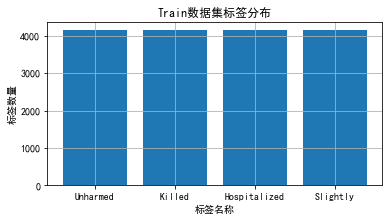

In [49]:
# 查看重新采样后的标签分布情况
sampledTrainDatasetLabelDistribute = computeLabelDistributeDict(sampledTrainDatasetDF)
plotLabelDistribute(sampledTrainDatasetLabelDistribute, 'Train数据集标签分布')

可以看到经过采样后，数据集标签分布较为均等

拆分特征和标签，方便后续训练

In [50]:
trainX = sampledTrainDatasetDF.drop(columns=['grav']).values
print(trainX.shape)
trainY = sampledTrainDatasetDF['grav'].values
print(trainY.shape)
valX = valDatasetDF.drop(columns=['grav']).values
print(valX.shape)
valY = valDatasetDF['grav'].values
print(valY.shape)
testX = testDatasetDF.values
print(testX.shape)

(16600, 26)
(16600,)
(2836, 26)
(2836,)
(2836, 26)


In [51]:
trainProcessedX = sampledTrainDatasetProcessedDF.drop(columns=['grav']).values
print(trainProcessedX.shape)
trainProcessedY = sampledTrainDatasetProcessedDF['grav'].values
print(trainProcessedY.shape)
valProcessedX = valDatasetProcessedDF.drop(columns=['grav']).values
print(valProcessedX.shape)
valProcessedY = valDatasetProcessedDF['grav'].values
print(valProcessedY.shape)

(16600, 172)
(16600,)
(2836, 172)
(2836,)


## 测试模型

随机森林包含150棵树

In [52]:
randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='entropy')

In [53]:
randomForestGini.fit(X=trainX, y=trainY)
# trainPredY = randomForestGini.predict(trainX)
# print('randomForestGini在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestGini.predict(valX)
print('randomForestGini在valDataset准确度', accuracy_score(valY, valPredY))


randomForestGini.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestGini.predict(trainProcessedX)
# print('randomForestGini在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestGini.predict(valProcessedX)
print('randomForestGini在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestGini在valDataset准确度 0.5578279266572638
randomForestGini在valProcessedDataset准确度 0.5317348377997179


In [54]:
randomForestEntropy.fit(X=trainX, y=trainY)
# trainPredY = randomForestEntropy.predict(trainX)
# print('randomForestEntropy在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestEntropy.predict(valX)
print('randomForestEntropy在valDataset准确度', accuracy_score(valY, valPredY))


randomForestEntropy.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestEntropy.predict(trainProcessedX)
# print('randomForestEntropy在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestEntropy.predict(valProcessedX)
print('randomForestEntropy在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestEntropy在valDataset准确度 0.5479548660084627
randomForestEntropy在valProcessedDataset准确度 0.5518335684062059


随机森林包含100棵树

In [55]:
randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='entropy')

In [56]:
randomForestGini.fit(X=trainX, y=trainY)
# trainPredY = randomForestGini.predict(trainX)
# print('randomForestGini在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestGini.predict(valX)
print('randomForestGini在valDataset准确度', accuracy_score(valY, valPredY))


randomForestGini.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestGini.predict(trainProcessedX)
# print('randomForestGini在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestGini.predict(valProcessedX)
print('randomForestGini在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestGini在valDataset准确度 0.5535966149506347
randomForestGini在valProcessedDataset准确度 0.5299717912552891


In [57]:
randomForestEntropy.fit(X=trainX, y=trainY)
# trainPredY = randomForestEntropy.predict(trainX)
# print('randomForestEntropy在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestEntropy.predict(valX)
print('randomForestEntropy在valDataset准确度', accuracy_score(valY, valPredY))


randomForestEntropy.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestEntropy.predict(trainProcessedX)
# print('randomForestEntropy在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestEntropy.predict(valProcessedX)
print('randomForestEntropy在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestEntropy在valDataset准确度 0.5500705218617772
randomForestEntropy在valProcessedDataset准确度 0.5479548660084627


随机森林包含200棵树

In [58]:
randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='entropy')

In [59]:
randomForestGini.fit(X=trainX, y=trainY)
# trainPredY = randomForestGini.predict(trainX)
# print('randomForestGini在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestGini.predict(valX)
print('randomForestGini在valDataset准确度', accuracy_score(valY, valPredY))


randomForestGini.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestGini.predict(trainProcessedX)
# print('randomForestGini在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestGini.predict(valProcessedX)
print('randomForestGini在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestGini在valDataset准确度 0.5606488011283498
randomForestGini在valProcessedDataset准确度 0.5419605077574048


In [60]:
randomForestEntropy.fit(X=trainX, y=trainY)
# trainPredY = randomForestEntropy.predict(trainX)
# print('randomForestEntropy在trainDataset准确度', accuracy_score(trainY, trainPredY))

valPredY = randomForestEntropy.predict(valX)
print('randomForestEntropy在valDataset准确度', accuracy_score(valY, valPredY))


randomForestEntropy.fit(X=trainProcessedX, y=trainProcessedY)
# trainPredProcessedY = randomForestEntropy.predict(trainProcessedX)
# print('randomForestEntropy在trainProcessedDataset准确度', accuracy_score(trainProcessedY, trainPredProcessedY))

valPredProcessedY = randomForestEntropy.predict(valProcessedX)
print('randomForestEntropy在valProcessedDataset准确度', accuracy_score(valProcessedY, valPredProcessedY))

randomForestEntropy在valDataset准确度 0.5546544428772919
randomForestEntropy在valProcessedDataset准确度 0.5490126939351199


从上述结果可以看出，不使用独热编码的效果优于使用独热编码。

故不采用独热编码的方式。

显然RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='gini')为测试中表现最好的模型。

## 结果测试

选出最好的随机森林模型(200棵树，gini)，并将其应用于测试集，以及结果导出

In [73]:
testResultPath = './Dataset/test_result.csv'

randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='gini')
randomForestGini.fit(X=trainX, y=trainY)

testPredYList = randomForestGini.predict(testX).tolist()
sampleIdx = [i for i in range(len(testPredYList))]

data = []

for idx in sampleIdx:
    data.append([idx, int(testPredYList[idx])])

testResultDF = pd.DataFrame(columns=['sample_id','grav'], data=data)
# print(testResultDF.info())

# 导出测试集预测结果
testResultDF.to_csv(path_or_buf=testResultPath, index=None)

求出在验证集上的准确度 Accuracy

In [72]:
valPredY = randomForestGini.predict(valX)
valDatasetAccuracy=accuracy_score(valPredY, valY)
print('randomForestGini在valDataset上的Accuracy : ', valDatasetAccuracy)

randomForestGini在valDataset上的Accuracy :  0.5606488011283498


求出每个类别的 precision、recall、F1-score

valConfusionMatrix :  [[573   8  66  98]
 [ 54 299 292  68]
 [ 67  90 354 143]
 [196  34 130 364]]
valConfusionMatrixType :  <class 'numpy.ndarray'>


<Figure size 1800x1800 with 0 Axes>

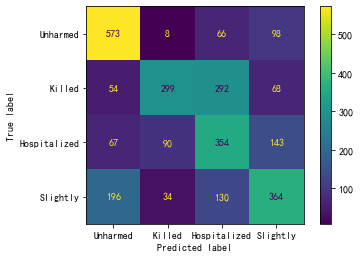

In [63]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

labels = ['Unharmed','Killed','Hospitalized','Slightly']

plt.figure(figsize=(25,25))
valConfusionMatrix = confusion_matrix(valY,valPredY)

print("valConfusionMatrix : ", valConfusionMatrix)
print("valConfusionMatrixType : ", type(valConfusionMatrix))


confusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=valConfusionMatrix, display_labels=labels)
confusionMatrixDisplay.plot()
plt.show()

In [64]:
from sklearn.metrics import precision_score,recall_score,f1_score

print("\nprecision_score 查准率")
precisonScore = precision_score(valY,valPredY,average=None)
print(precisonScore)


print("\nrecall_score 查全率")
recallScore = recall_score(valY,valPredY,average=None)
print(recallScore)


print("\nf1_score F1")
f1Score = f1_score(valY,valPredY,average=None)
print(f1Score)


precision_score 查准率
[0.64382022 0.6937355  0.42042755 0.54086181]

recall_score 查全率
[0.76912752 0.41935484 0.5412844  0.50276243]

f1_score F1
[0.70091743 0.52272727 0.47326203 0.52111668]


通过反复的测试，最终选择了拥有200棵树的以Gini系数为划分选择的随机森林作为最好的模型，并且使用了bootstrap采样。

虽然在val集上的Accuracy超过了55%，但是从混淆矩阵以及precision、recall、F1-score等指标可以看出一些问题。

首先该模型容易将真实类别为Killed的样本，误判为Hospitalized Injured。同时对于Slightly Injured也比较容易判为Unharmed。这两点其实也情有可原，因为这两组label本身也比较接近。

但是Hospitalized和Slightly有时也会分不清，这一点是今后需要改进的地方。


## 结语

我的模型在验证集上的表现的准确率并不是很高，只有56%。

想要了解一下岑老师训练的模型最终能在验证集上有多好的表现。这样能够让我了解还有多少进步空间。

以后有时间会学习更多的机器学习算法，对本问题继续研究。


## 模型选择实验结果部分记录

//6

randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='entropy')
randomForestGini在valDataset准确度 0.5476022566995769
randomForestGini在valProcessedDataset准确度 0.5412552891396333
randomForestEntropy在valDataset准确度 0.5430183356840621
randomForestEntropy在valProcessedDataset准确度 0.5440761636107193


randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='entropy')
randomForestGini在valDataset准确度 0.5493653032440057
randomForestGini在valProcessedDataset准确度 0.5405500705218618
randomForestEntropy在valDataset准确度 0.5423131170662906
randomForestEntropy在valProcessedDataset准确度 0.5384344146685472


randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='entropy')
randomForestGini在valDataset准确度 0.5500705218617772
randomForestGini在valProcessedDataset准确度 0.5447813822284908
randomForestEntropy在valDataset准确度 0.5401974612129761
randomForestEntropy在valProcessedDataset准确度 0.5472496473906912


//8

randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=150, criterion='entropy')
randomForestGini在valDataset准确度 0.5578279266572638
randomForestGini在valProcessedDataset准确度 0.5317348377997179
randomForestEntropy在valDataset准确度 0.5479548660084627
randomForestEntropy在valProcessedDataset准确度 0.5518335684062059


randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=100, criterion='entropy')
randomForestGini在valDataset准确度 0.5535966149506347
randomForestGini在valProcessedDataset准确度 0.5299717912552891
randomForestEntropy在valDataset准确度 0.5500705218617772
randomForestEntropy在valProcessedDataset准确度 0.5479548660084627


randomForestGini = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='gini')
randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='entropy')
randomForestGini在valDataset准确度 0.5606488011283498
randomForestGini在valProcessedDataset准确度 0.5419605077574048
randomForestEntropy在valDataset准确度 0.5546544428772919
randomForestEntropy在valProcessedDataset准确度 0.5490126939351199

